In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, month_plot
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import evds as ev

In [3]:
data = pd.read_csv("AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
data.rename(columns={"Month":"Date", "#Passengers":"Passengers"}, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
data["Date"] = pd.date_range("1949-01-01", periods=len(data), freq="M")

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [12]:
data.set_index("Date", inplace=True)
data.isnull().sum()

Passengers    0
dtype: int64

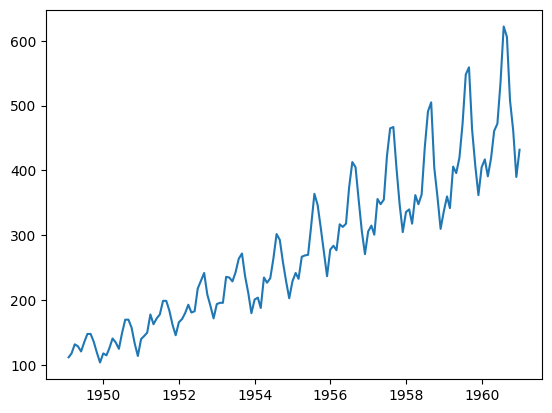

In [13]:
#Lets quick check if there are seasonality and trend in the series.
plt.plot(data)
plt.show ()

#we can see there are seasonality and trend by looking at graph below.

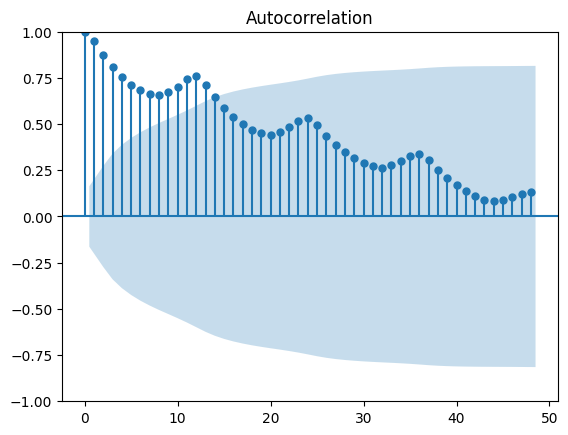

In [15]:
# We can observe seasonality and trend via ACF.
plot_acf(data, lags=48)
plt.show()

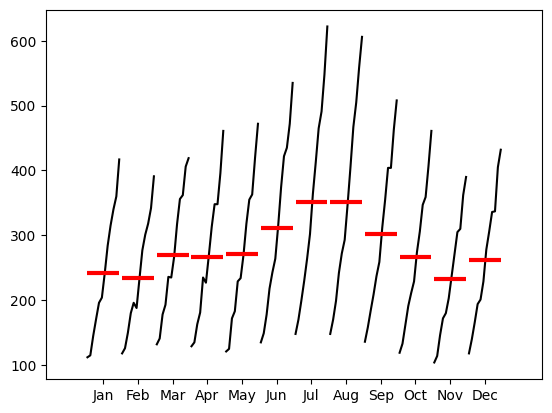

In [16]:
month_plot(data)
plt.show()
# we can see there are increasing passengers number in summer while decreasing in winter.

In [17]:
# lets split the data as train and test datasets
train = data.iloc[:-24]
test = data.iloc[-24:]

In [20]:
#cheking whether the series is stationary with ADF nd KPSS statistical tests.
adf = ADF(train)
kpss = KPSS(train)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.773
P-value                         0.827
Lags                               13
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.706
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


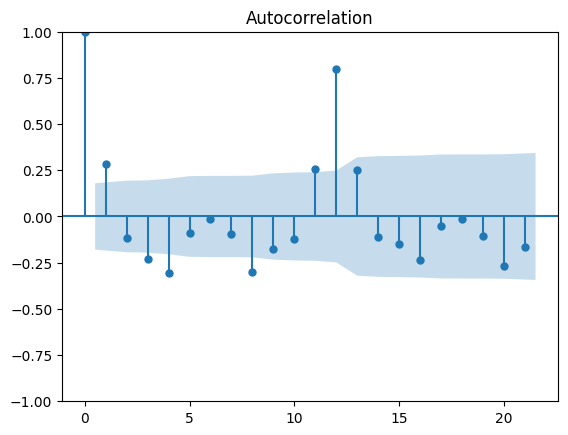

In [22]:
# difference taking of lag values
datadiff = train.diff().dropna()

plot_acf(datadiff)
plt.show()

In [25]:
adf = ADF(datadiff)
kpss = KPSS(datadiff)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.164
P-value                         0.220
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.019
P-value                         0.996
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


As we look at the graph above and kpss and adf test results, we can see we get rid of trend structure but still the series has high autocorrelation point.at the same time ADF and KPSS test gave different results KPSS says the series has stationary after taking 1 lag while ADF says it is non-stationary. Because the series has seasonality so it still has the problem of non-stationarity.
Therefore we need to take difference of lag for seasonality period.

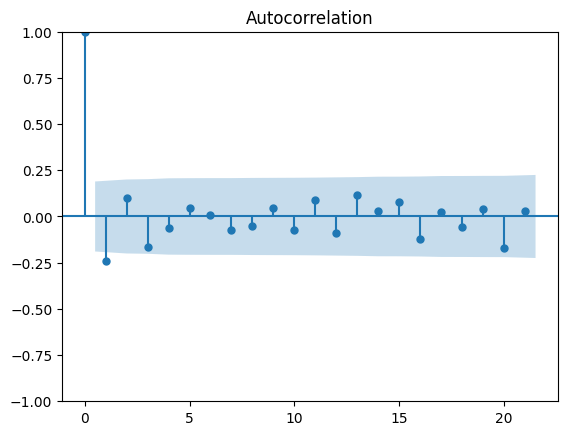

In [24]:
datadiffseason = datadiff.diff(12).dropna()

plot_acf(datadiffseason)
plt.show()

In [26]:
adf = ADF(datadiffseason)
kpss = KPSS(datadiffseason)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                -13.052
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.109
P-value                         0.545
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


Now both statistical results says the series is stationary and we can understand it with acf plot graph.

In [27]:
# Set up the model
model = auto_arima(train, trace=True, seasonal=True, m=12)
print(model)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=813.746, Time=1.29 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.28 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.55 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.06 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.34 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.29 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AIC=809.375, Time=0.11 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.08 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept  

In [30]:
# Auto arima model use d parameter 0 as default lets try different d values and compare the result
model = auto_arima(train, trace=True, seasonal=True, m=12, d=1)
print(model)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=807.655, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.973, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=805.408, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=803.281, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=805.044, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=805.093, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=804.813, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=803.650, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=806.793, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=805.281, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.873 seconds
 ARIMA(1,1,0)(0,1,0)[12]          


In [31]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -399.641
Date:                            Sun, 24 Dec 2023   AIC                            803.281
Time:                                    21:40:33   BIC                            808.627
Sample:                                01-31-1949   HQIC                           805.448
                                     - 12-31-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2397      0.091     -2.629      0.009      -0.418      -0.061
sigma2       102.6681     12.363   

In [32]:
# now check if the error has white noise or not
error = model.resid()

q = acorr_ljungbox(error)
print(q)



     lb_stat  lb_pvalue
1   0.000411   0.983819
2   0.617111   0.734507
3   0.983062   0.805350
4   1.283585   0.864154
5   1.675589   0.891961
6   1.726353   0.943069
7   2.459555   0.930112
8   3.138440   0.925371
9   3.387549   0.946932
10  4.800462   0.904102


all p values are not meaningfull so the series is in the white noise process.

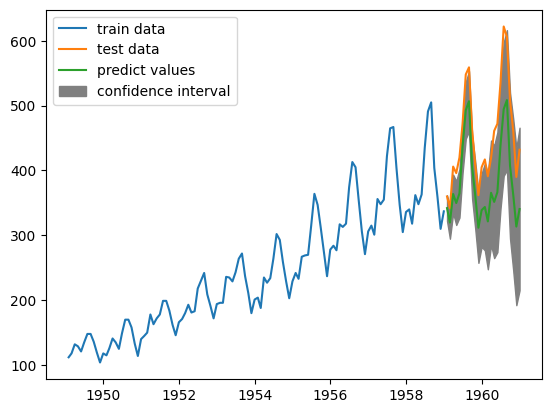

In [33]:
# predict test data values
prediction, ci = model.predict(24, return_conf_int=True)

plt.plot(train, label="train data")
plt.plot(test, label="test data")
plt.plot(prediction, label="predict values")
plt.fill_between(prediction.index, ci[:,0], ci[:,1], color="gray", label="confidence interval")
plt.legend()
plt.show()

In [2]:
# Example 2

with open("/Users/neseuygun/Desktop/evds_api_key.txt") as file:
    api = file.read()

evds = ev.evdsAPI(api)
data = evds.get_data(["TP.FG.J0"],startdate="01-01-2003", enddate="01-12-2017")
data

,Tarih,TP_FG_J0
0,2003-1,94.77
1,2003-2,96.23
2,2003-3,98.12
3,2003-4,99.09
4,2003-5,100.04
...,...,...
175,2017-8,311.85
176,2017-9,313.88
177,2017-10,320.40
178,2017-11,325.18


In [3]:
data.rename(columns={"Tarih":"Date", "TP_FG_J0":"CPI"}, inplace=True)
data["Date"] = pd.date_range("2003-01-01", periods=len(data), freq="M")
data

,Date,CPI
0,2003-01-31,94.77
1,2003-02-28,96.23
2,2003-03-31,98.12
3,2003-04-30,99.09
4,2003-05-31,100.04
...,...,...
175,2017-08-31,311.85
176,2017-09-30,313.88
177,2017-10-31,320.40
178,2017-11-30,325.18


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    180 non-null    datetime64[ns]
 1   CPI     180 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.9 KB


In [5]:
data.set_index("Date", inplace=True)

In [6]:
data.isnull().sum()

CPI    0
dtype: int64

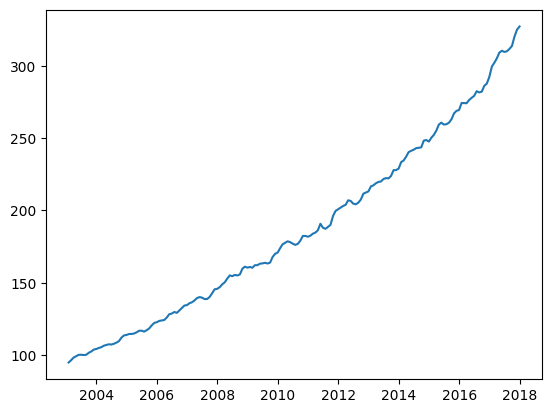

In [7]:
plt.plot(data)
plt.show()

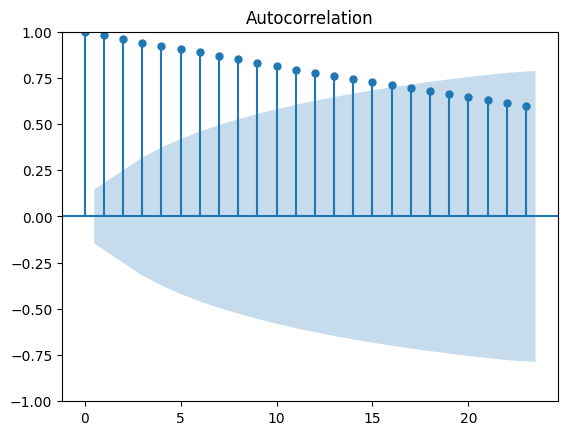

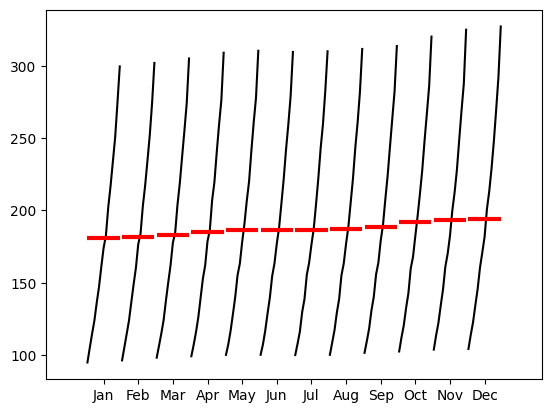

In [8]:
plot_acf(data)
month_plot(data)
plt.show()

As we see in both graph above, there is a trend in the series and not seasonality

In [9]:
# Now split the data
train = data.iloc[:-24]
test = data.iloc[-24:]

In [10]:
# Now apply unit root test if there is stationary or not
adf = ADF(train)
kpss = KPSS(train)
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                  3.805
P-value                         1.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.818
P-value                         0.000
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


Both test we can see there is unit root problem so the series is not stationaru

In [11]:
# Not lets take difference for 1 lag to be able to make stationary the series
datadiff = train.diff().dropna()
adf = ADF(datadiff)
kpss = KPSS(datadiff)
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.202
P-value                         0.206
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.625
P-value                         0.019
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


Still the series is not stationary. So we need to take second difference

In [12]:
datadiff2 = train.diff().diff().dropna()
adf = ADF(datadiff2)
kpss = KPSS(datadiff2)
print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -9.594
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.044
P-value                         0.915
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


Now we could make stationary the series by taking difference second time

In [13]:
# set up the model
model = auto_arima(train, trace=True, seasonal=False)
print(model)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=609.606, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=599.205, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=607.608, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=576.637, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=578.351, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=574.637, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=597.207, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=576.351, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=531.597, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=536.948, Time=0.02 sec
 A

In [14]:
model2 = auto_arima(train, trace=True, seasonal=False, information_criterion="bic")
print(model2)

Performing stepwise search to minimize bic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : BIC=615.680, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : BIC=608.315, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=610.645, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : BIC=588.785, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : BIC=593.535, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0]             : BIC=583.748, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : BIC=603.280, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : BIC=588.499, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0]             : BIC=543.745, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : BIC=546.058, Time=0.02 sec
 A

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 2, 3)   Log Likelihood                -252.428
Date:                Tue, 26 Dec 2023   AIC                            516.856
Time:                        20:22:17   BIC                            535.078
Sample:                    01-31-2003   HQIC                           524.258
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0031      0.001      3.370      0.001       0.001       0.005
ar.L1          0.5080      0.134      3.786      0.000       0.245       0.771
ma.L1         -1.3158      0.119    -11.017      0.000      -1.550      -1.082
ma.L2         -0.1921      0.170     -1.128      0.259      -0.526       0.142
ma.L3          0.5130      0.066      7.739      0.000       0.383       0.643
sigma2         1.4727      0.160      9.213      0.000       1.159       1.786
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                11.75
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 2, 3)   Log Likelihood                -254.356
Date:                Tue, 26 Dec 2023   AIC                            518.711
Time:                        20:22:18   BIC                            533.896
Sample:                    01-31-2003   HQIC                           524.879
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6213      0.104      5.982      0.000       0.418       0.825
ma.L1         -1.4026      0.096    -14.601      0.000      -1.591      -1.214
ma.L2         -0.0705      0.154     -0.458      0.647      -0.372       0.231
ma.L3          0.4927      0.069      7.176      0.000       0.358       0.627
sigma2         1.5442      0.143     10.824      0.000       1.265       1.824
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                16.79
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               4.82   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# we will remove ma.L2 since its pvalue is not meaningfull. This approach is optional we do not have to remove it.
model3 = ARIMA(train, order=(1,2, [1,3])).fit()
model3.summary()


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/neseuygun/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/neseuygun/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                     CPI   No. Observations:                  156
Model:             ARIMA(1, 2, [1, 3])   Log Likelihood                -254.357
Date:                 Tue, 26 Dec 2023   AIC                            516.714
Time:                         20:29:45   BIC                            528.862
Sample:                     01-31-2003   HQIC                           521.648
                          - 12-31-2015                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6240      0.092      6.774      0.000       0.443       0.804
ma.L1         -1.5315      0.031    -49.040      0.000      -1.593      -1.470
ma.L3          0.5522      0.033     16.935      0.000       0.488       0.616
sigma2         1.3641      0.179      7.608      0.000       1.013       1.715
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                17.01
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# lets observe white noise process for three models.
q1 = acorr_ljungbox(model.resid())
q2 = acorr_ljungbox(model2.resid())
q3 = acorr_ljungbox(model3.resid)

print(q1)
print(q2)
print(q3)

      lb_stat  lb_pvalue
1   23.692865   0.000001
2   23.704238   0.000007
3   23.708136   0.000029
4   23.708213   0.000091
5   23.717439   0.000246
6   23.717557   0.000589
7   23.731347   0.001270
8   23.731677   0.002542
9   23.736514   0.004738
10  23.739427   0.008323
      lb_stat  lb_pvalue
1   23.731441   0.000001
2   23.739765   0.000007
3   23.743502   0.000028
4   23.743521   0.000090
5   23.752858   0.000242
6   23.753045   0.000580
7   23.767305   0.001252
8   23.767411   0.002507
9   23.772477   0.004676
10  23.773847   0.008224
      lb_stat  lb_pvalue
1   23.724940   0.000001
2   23.733090   0.000007
3   23.736766   0.000028
4   23.736795   0.000090
5   23.746042   0.000243
6   23.746236   0.000581
7   23.760458   0.001255
8   23.760556   0.002513
9   23.765545   0.004688
10  23.766863   0.008244


In 3 models there are not white noise process. It means our models miss some important relation. 

In [24]:
# Now we will try different models to solve the problem that models are not in white noise process.
holt = Holt(train)
model4 = holt.fit(optimized=True, use_brute=True)

/Users/neseuygun/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [25]:
# prediction next 24 months values
prediction1 = model.predict(24)
prediction2 = model2.predict(24)
prediction3 = model3.forecast(24)
prediction4 = model4.forecast(24)

In [40]:
def error(y_true, y_pred):
    print("MSE: {}".format(mean_squared_error(y_true, y_pred)))
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("MAE: {}".format(mean_absolute_error(y_true, y_pred)))
    print("R2: {}".format(r2_score(y_true, y_pred)))

print("###### Model 1 ######")
error(test, prediction1)
print("\n###### Model 2 ######")
error(test, prediction2)
print("\n###### Model 3 ######")
error(test, prediction3)
print("\n###### Model 4 ######")
error(test, prediction4)

###### Model 1 ######
MSE: 75.40247336219457
RMSE: 8.683459757619342
MAE: 6.569319993923223
R2: 0.7433100736012279

###### Model 2 ######
MSE: 86.47066003706487
RMSE: 9.298960158913731
MAE: 6.968863187979456
R2: 0.7056310440381897

###### Model 3 ######
MSE: 86.49774481571302
RMSE: 9.30041637862053
MAE: 6.97009180084591
R2: 0.705538840300995

###### Model 4 ######
MSE: 136.95954604873762
RMSE: 11.702971675977757
MAE: 8.961756116025265
R2: 0.5337535464388845


Model 1 is best model while model 4 has worst error results 